# Automatidata - Machine Learning Model

This work involves building a tree-based model to predict a binary target variable. The primary aim is to help taxi drivers maximize their earnings by predicting which customers are likely to tip generously.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
# reading the data, the key features and the predicted fares from the regression analysis
df0 = pd.read_csv("2017_Yellow_Taxi_Trip_Data.csv")
nyc_preds_means = pd.read_csv("nyc_preds_means.csv")

# merging the two datasets
df0 = df0.merge(nyc_preds_means, left_index=True, right_index=True)
df0.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,...,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,...,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,...,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,...,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,...,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,...,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351
6,37660487,2,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,1,12.83,1,N,79,241,...,47.5,1.0,0.5,9.86,0.0,0.3,59.16,59.633333,12.830000,45.374542
7,69059411,2,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,1,2.98,1,N,237,114,...,16.0,1.0,0.5,1.78,0.0,0.3,19.58,26.437500,4.022500,18.555128
8,8433159,2,02/04/2017 4:17:07 PM,02/04/2017 4:29:14 PM,1,1.20,1,N,234,249,...,9.0,0.0,0.5,0.00,0.0,0.3,9.80,7.873457,1.019259,7.151511
9,95294817,1,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,1,1.60,1,N,239,237,...,13.0,0.0,0.5,2.75,0.0,0.3,16.55,10.541111,1.580000,9.122755


In [ ]:
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


In [ ]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [ ]:
df0.describe()

,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
count,2.269900e+04,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,5.675849e+07,1.556236,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502,14.460555,2.913313,12.979534
std,3.274493e+07,0.496838,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295,10.080913,3.558993,9.706126
min,1.212700e+04,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000,0.000000,0.000000,2.934494
25%,2.852056e+07,1.000000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000,8.031481,1.010000,7.396030
50%,5.673150e+07,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000,11.556667,1.620000,9.560801
75%,8.537452e+07,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000,17.321667,3.115625,13.933373
max,1.134863e+08,2.000000,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000,88.783333,33.920000,89.171050


There are a few practical and ethical considerations. If the model predicts a tip but the customer does not leave one, this false positive may frustrate drivers. On the other hand, a false negative (predicting no tip when a tip is given) might discourage drivers from picking up customers who would have been generous. Consistently inaccurate predictions could damage trust in the app and potentially lead to fewer rides for some customers, limiting their access to taxi services. The model's potential to dissuade drivers from picking up certain passengers could lead to customer dissatisfaction, which might outweigh any financial benefits to drivers. Restricting access to taxi services based on predictions could be seen as ethically problematic and pose significant risks. This are the main reasons why the focus has been shifted to predicting the most generous customers instead. This adjustment can help drivers earn more tips without excluding passengers unfairly. Important features include a passenger's past tipping behavior, times and locations of trips, estimated fares and payment method. The target variable is a binary indicator that signifies whether the customer is likely to tip 20% or more.

In [ ]:
def check_rush_hour_am(hour):
    """
    This function checks if a given hour belongs in the interval [06:00–10:00).
    """
    if 6 <= hour["am_rush"] < 10:
        return 1
    return 0


def check_rush_hour_pm(hour):
    """
    This function checks if a given hour belongs in the interval [16:00–20:00).
    """
    if 16 <= hour["pm_rush"] < 20:
        return 1
    return 0


def check_daytime(hour):
    """
    This function checks if a given hour belongs in the interval [10:00–16:00).
    """
    if 10 <= hour["daytime"] < 16:
        return 1
    return 0


def check_nighttime(hour):
    """
    This function checks if a given hour belongs in the interval [20:00–06:00).
    """
    if 20 <= hour["nighttime"] < 24 or 0 <= hour["nighttime"] < 6:
        return 1
    return 0

In [ ]:
# isolating customers who paid with credit card
df1 = df0[df0["payment_type"]==1]

# converting datetime columns to datetime format
df1["tpep_pickup_datetime"] = pd.to_datetime(df1["tpep_pickup_datetime"], format="%m/%d/%Y %I:%M:%S %p")
df1["tpep_dropoff_datetime"] = pd.to_datetime(df1["tpep_dropoff_datetime"], format="%m/%d/%Y %I:%M:%S %p")

# creating new column for the tip percentage
df1["tip_percent"] = round(df1["tip_amount"] / (df1["total_amount"] - df1["tip_amount"]), 3)

# creating new column for the generous tippers
df1["generous"] = df1["tip_percent"]
df1["generous"] = (df1["generous"] >= 0.2)
df1["generous"] = df1["generous"].astype(int)

# creating new column for the day
df1["day"] = df1["tpep_pickup_datetime"].dt.day_name().str.lower()

# creating new column for the month
df1["month"] = df1["tpep_pickup_datetime"].dt.strftime("%b").str.lower()

# creating new column for the early rush hour
df1["am_rush"] = df1["tpep_pickup_datetime"].dt.hour
df1["am_rush"] = df1.apply(check_rush_hour_am, axis=1)

# creating new column for the late rush hour
df1["pm_rush"] = df1["tpep_pickup_datetime"].dt.hour
df1["pm_rush"] = df1.apply(check_rush_hour_pm, axis=1)

# creating new column for the day-time
df1["daytime"] = df1["tpep_pickup_datetime"].dt.hour
df1["daytime"] = df1.apply(check_daytime, axis=1)

# creating new column for the night-time
df1["nighttime"] = df1["tpep_pickup_datetime"].dt.hour
df1["nighttime"] = df1.apply(check_nighttime, axis=1)

In [ ]:
# dropping unnecessary columns
drop_cols = ["Unnamed: 0", "tpep_pickup_datetime", "tpep_dropoff_datetime",
             "payment_type", "trip_distance", "store_and_fwd_flag", "payment_type",
             "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount",
             "improvement_surcharge", "total_amount", "tip_percent"]

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  month            15265 non-null  object 
 11  am_rush          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  daytime          15265 non-null  int64  
 14  nighttime        15265 non-null  int64  
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


In [ ]:
# converting certain columns to string
columns_to_str = ["RatecodeID", "PULocationID", "DOLocationID", "VendorID"]
for col in columns_to_str:
    df1[col] = df1[col].astype("str")

# converting categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)

# getting class balance for the generous tippers
df2["generous"].value_counts(normalize=True)

,proportion
generous,
1,0.526368
0,0.473632


Metrics such as accuracy, precision, recall, F1 score and ROC AUC are relevant, with F1 score being appropriate due to its balance between precision and recall. Creating a feature for the tip percentage (by calculating the tip amount divided by the fare excluding the tip) is crucial. Rounding this result to three decimal places ensures accurate classification of generous tippers. Additionally, we see that the dataset is nearly balanced, with about half of the customers classified as "generous" tippers.

In [ ]:
def get_best_cv_results(model_name:str, model_object, metric:str):
    """
    This function returns a dataframe with the performance scores for the model
    with the best mean of a given metric across all validation folds.
    """
    # creating dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {"precision": "mean_test_precision",
                   "recall": "mean_test_recall",
                   "f1": "mean_test_f1",
                   "accuracy": "mean_test_accuracy"}

    # getting all the results from the CV
    cv_results = pd.DataFrame(model_object.cv_results_)

    # isolating the row of the dataframe with the max score of the given metric
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # extracting performance scores
    accuracy = best_estimator_results.mean_test_accuracy
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision

    # creating table of results
    table = pd.DataFrame({"model": [model_name],
                          "precision": [precision],
                          "recall": [recall],
                          "F1": [f1],
                          "accuracy": [accuracy]})
    return table


def get_test_results(model_name:str, preds, y_test_data):
    """
    This function generates a table of test scores (precision, recall, f1, accuracy).
    """
    # calculating performance scores
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    # creating table of results
    table = pd.DataFrame({"model": [model_name],
                          "precision": [precision],
                          "recall": [recall],
                          "F1": [f1],
                          "accuracy": [accuracy]})
    return table


def plot_confusion_matrix(y_target, y_pred, clf_cv, title):
    """
    This function plots the confusion matrix based on given actual and predicted values.
    """
    # generating array of values for confusion matrix
    log_cm = confusion_matrix(y_target, y_pred, labels=clf_cv.classes_)

    # plotting confusion matrix
    log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=clf_cv.classes_)
    log_disp.plot()
    plt.title(title)
    plt.show()

False positives (incorrectly predicting a tip) could upset drivers, while false negatives (failing to predict a generous tip) could cost customers their rides. The F1 score is most suitable as it balances the cost of both types of errors. Testing multiple models enables comparison using data not used in training, minimizing the risk of overfitting. However, choosing a model based on this test data can introduce bias into performance estimates.

In [ ]:
# isolating the features (X) and the target variable (y)
y = df2["generous"]
X = df2.drop("generous", axis=1)

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# hyperparameters for tuning
cv_params = {"max_depth": [5, 10, 15, None],
             "max_features": [0.3, 0.6, 0.9, 1.0],
             "max_samples": [0.5, 0.7, 0.9, 1.0],
             "min_samples_leaf": [1, 2, 4, 6],
             "min_samples_split": [2, 4, 6],
             "n_estimators": [75, 100, 200]}

# scoring metrics
scoring_criteria = ["accuracy", "precision", "recall", "f1"]

# GridSearchCV object
rf_cv = GridSearchCV(rf_clf, cv_params, scoring=scoring_criteria, cv=5, refit="f1")

In [ ]:
rf_cv.fit(X_train, y_train)

In [ ]:
# examining best score
rf_cv.best_score_

0.7188564347411132

In [ ]:
# examining best architecture
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
# getting best results based on a specific metric
results = get_best_cv_results("Random Forest Train", rf_cv, "f1")
results

,model,precision,recall,F1,accuracy
0,Random Forest Train,0.680002,0.762601,0.718856,0.686128


In [ ]:
# getting scores on test data
rf_preds = rf_cv.best_estimator_.predict(X_test)
rf_test_scores = get_test_results("Random Forest Test", rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest Train,0.680002,0.762601,0.718856,0.686128
0,Random Forest Test,0.670784,0.777225,0.720092,0.681952


In [ ]:
# XGBoost classifier
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0)

# hyperparameters for tuning
cv_params = {"learning_rate": [0.1, 0.01, 0.001],
             "max_depth": [6, 8, 10, 12],
             "min_child_weight": [1, 3, 5],
             "n_estimators": [300, 400, 500]}

# scoring metrics
scoring_criteria = ["accuracy", "precision", "recall", "f1"]

# GridSearchCV object
xgb_cv = GridSearchCV(xgb_clf, cv_params, scoring=scoring_criteria, cv=5, refit="f1")

In [ ]:
xgb_cv.fit(X_train, y_train)

In [ ]:
# examining best score
xgb_cv.best_score_

0.7090769139686336

In [ ]:
# examining best architecture
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 500}

In [ ]:
# getting best results based on a specific metric
xgb_cv_cv_results = get_best_cv_results("XGBoost Train", xgb_cv, "f1")
results = pd.concat([results, xgb_cv_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest Train,0.680002,0.762601,0.718856,0.686128
0,Random Forest Test,0.670784,0.777225,0.720092,0.681952
0,XGBoost Train,0.679115,0.742065,0.709077,0.679576


In [ ]:
# getting scores on test data
xgb_preds = xgb_cv.best_estimator_.predict(X_test)
xgb_test_scores = get_test_results("XGBoost Test", xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest Train,0.680002,0.762601,0.718856,0.686128
0,Random Forest Test,0.670784,0.777225,0.720092,0.681952
0,XGBoost Train,0.679115,0.742065,0.709077,0.679576
0,XGBoost Test,0.681391,0.767890,0.722060,0.688831


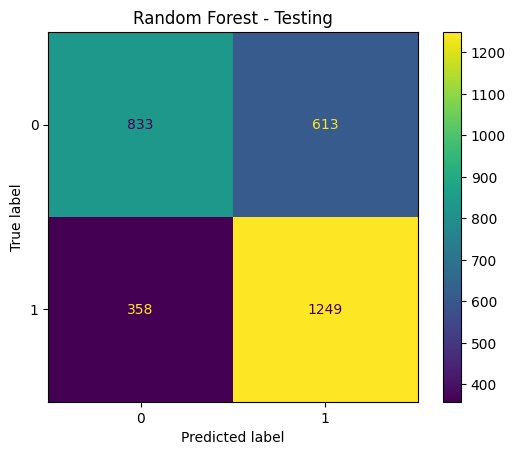

In [ ]:
# plotting confusion matrix for the best model
plot_confusion_matrix(y_test, rf_preds, rf_cv, "Random Forest - Testing")

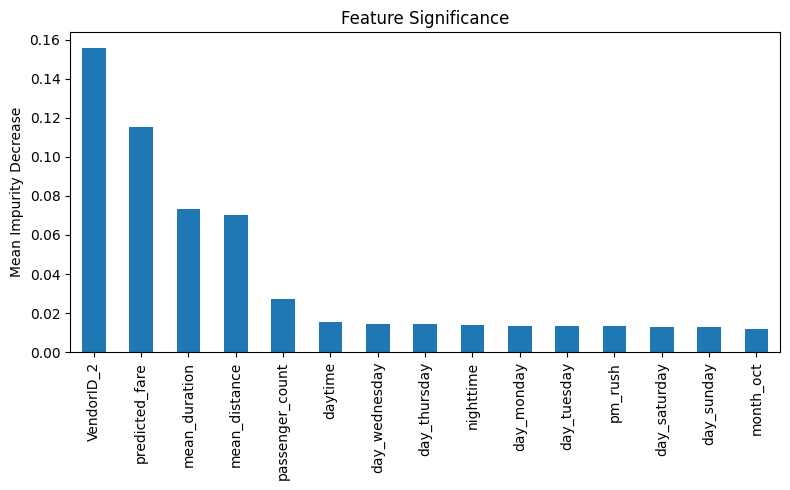

In [ ]:
# visualizing the feature significance
feature_significance = rf_cv.best_estimator_.feature_importances_
rf_feature_significance = pd.Series(feature_significance, index=X_test.columns)
rf_feature_significance = rf_feature_significance.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_feature_significance.plot.bar(ax=ax)
ax.set_title("Feature Significance")
ax.set_ylabel("Mean Impurity Decrease")
fig.tight_layout()

The two models have approximately the same F1 score, with the random forest model having a slightly higher F1 score in training than the alternative model. The random forest model tended to produce more false positives, which could be less desirable, but overall the model performed well. The model is suitable for limited testing with taxi drivers as it offers a good balance of precision and recall. Its F1 score was 72% and its accuracy was 68%, making it a promising tool for predicting tipping behavior. While random forest models lack transparency, the most important predictive features identified include VendorID, predicted fare, mean trip duration and mean distance. VendorID's high importance suggests that different vendors may attract varying customer tipping behaviors. This warrants further statistical analysis. Additional features, such as trip distance categorization (short, medium, long) and the ratio of fare values relative to multiples of \$5 or \$10, could potentially enhance model accuracy. These features could capture customer tendencies to round their tips. Having access to historical tipping behavior, accurate data for cash tips and a larger dataset would also likely boost model performance. It is important to recognize that sometimes the available data may not be predictive enough. In such cases, even advanced models may fail to produce reliable outcomes. However, even unsuccessful models can offer valuable insights for stakeholders.